In [77]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# print("Path to dataset files:", path)

In [3]:
def remove_ds_store_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == '.DS_Store':
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Removed: {file_path}")
                except Exception as e:
                    print(f"Error removing {file_path}: {e}")

remove_ds_store_files('data/versions/1')

In [4]:
data_dir = 'data/versions/1'
file_paths = []
labels = []

for actor_dir in sorted(os.listdir(data_dir)):
    actor_path = os.path.join(data_dir, actor_dir)
    for file_name in sorted(os.listdir(actor_path)):
        file_path = os.path.join(actor_path, file_name)
        emotion = int(file_name.split("-")[2])
        labels.append(emotion)
        file_paths.append(file_path)

In [5]:
def add_noise(signal, noise_factor=0.035):
    noise = np.random.normal(0, 1, signal.shape)
    amplitude = noise_factor * np.max(signal)
    noisy_data = signal + amplitude * noise
    return noisy_data

def stretch(signal, rate=0.7):
    return librosa.effects.time_stretch(y=signal, rate=rate)

def shift(signal, shift_range=(-5, 5)):
    shift_amount = np.random.randint(*shift_range) * 1000
    return np.roll(signal, shift_amount)

def pitch(signal, sampling_rate=48000, step=1):
    return librosa.effects.pitch_shift(y=signal, sr=sampling_rate, n_steps=step)


In [8]:
# ZCR, MFCCS, Roll off, spectral contrast, chroma cqt, tonnetz, rms, mel_spectrogram
def extract_features(file_path, to_add_noise=False, to_stretch=False, to_shift=False, to_pitch=False, sample_rate=48000):
    signal, sr = librosa.load(file_path, sr=sample_rate)
    signal, _  = librosa.effects.trim(signal)
    
    if to_add_noise:
        signal = add_noise(signal)
    if to_stretch:
        signal = stretch(signal)
    if to_shift:
        signal = shift(signal)
    if to_pitch:
        signal = pitch(signal)
    
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=signal, frame_length=512))
    mfccs = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=5, n_fft=512).T, axis=0)
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=512))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=512), axis=1)
    chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=signal, sr=sr), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=signal, sr=sr), axis=1)
    rms = np.mean(librosa.feature.rms(y=signal, frame_length=512))
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=10, n_fft=512), axis=1)
    
    features = np.hstack([zcr, mfccs, spectral_rolloff, spectral_contrast, chroma_cqt, tonnetz, rms, mel_spectrogram])
    return features

    # chroma_stft = np.mean(librosa.feature.chroma_stft(y=signal, sr=sr), axis=1)
    # mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=40), axis=1)
    # spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=signal, sr=sr))
    # spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=signal, sr=sr))
    # tonnetz = np.mean(librosa.feature.tonnetz(y=signal, sr=sr), axis=1)
    # chroma_cens = np.mean(librosa.feature.chroma_cens(y=signal, sr=sr), axis=1)
    # spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=signal))
    # rms = np.mean(librosa.feature.rms(y=signal))

    # features = np.hstack([
    #     mfccs, chroma_stft, mel_spectrogram, spectral_centroid, spectral_bandwidth, 
    #     tonnetz, zcr, chroma_cqt, chroma_cens, spectral_contrast, 
    #     spectral_flatness, spectral_rolloff, rms
    # ])


In [9]:
print(extract_features(file_paths[1], to_pitch=True))
print(extract_features(file_paths[1], to_pitch=False))

/opt/anaconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=892
  warnings.warn(


[ 1.48315430e-01 -8.50023254e+02  5.62338448e+01 -1.89763527e+01
  6.43742657e+00  9.09645939e+00  1.00015346e+04  4.22267288e+00
  2.86958822e+00  6.55011347e+00  9.30213167e+00  1.19023261e+01
  1.64447154e+01  4.15332123e+01  4.17904615e-01  4.34651852e-01
  4.87610906e-01  4.20892477e-01  4.34686005e-01  4.14236724e-01
  5.15738547e-01  4.35890347e-01  3.93865973e-01  4.48291302e-01
  5.13703108e-01  6.36532784e-01  2.18513505e-02 -3.67294306e-02
  3.65165172e-02 -6.43708161e-02 -8.26884390e-03 -8.78033690e-05
  1.91765837e-03  6.90856308e-04  2.92985700e-04  7.20406169e-05
  3.13020173e-05  7.60205921e-06  4.83592066e-06  1.55704026e-06
  3.29273320e-07  2.28456614e-07  5.56873339e-08]
[ 6.15059989e-02 -8.32208618e+02  6.06197205e+01 -1.75558643e+01
  6.74108219e+00  9.14315319e+00  1.01028181e+04  3.21284471e+00
  2.38659027e+00  6.47952031e+00  9.02629097e+00  1.08916942e+01
  1.54729069e+01  1.80709301e+01  4.96907532e-01  5.03493190e-01
  3.65827978e-01  4.09152567e-01  3.5434

In [66]:
features = []


for file_path in tqdm(file_paths):
    feature = extract_features(file_path=file_path, to_pitch=True)
    features.append(feature)

  0%|          | 0/1440 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=796
  warnings.warn(
  0%|          | 1/1440 [00:00<05:16,  4.55it/s]/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=892
  warnings.warn(
  0%|          | 2/1440 [00:00<04:30,  5.32it/s]/opt/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=948
  warnings.warn(
  0%|          | 5/1440 [00:01<05:05,  4.70it/s]/opt/anaconda3/lib/python3.11/site-p

In [67]:
df = pd.DataFrame(features)
df.to_csv('features.csv', index=False)

In [78]:
df = pd.read_csv('features.csv')

In [79]:
df

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.126660,-843.171936,63.669731,-16.689051,6.921993,9.694711,9033.750000,4.028210,2.831416,6.330519,...,0.000838,0.000322,0.000041,0.000029,0.000011,0.000007,1.687684e-06,2.710978e-07,1.415529e-07,4.313261e-08
1,0.148315,-850.023254,56.233845,-18.976353,6.437427,9.096459,10001.534598,4.222673,2.869588,6.550113,...,0.000691,0.000293,0.000072,0.000031,0.000008,0.000005,1.557040e-06,3.292733e-07,2.284566e-07,5.568733e-08
2,0.178588,-877.330994,54.419193,-16.309053,5.420001,7.059585,10810.399160,3.611877,2.594524,5.913460,...,0.000890,0.000409,0.000114,0.000030,0.000008,0.000008,8.140895e-06,1.087136e-06,6.043251e-07,1.234914e-07
3,0.189729,-882.071777,44.574593,-9.328506,6.729323,6.495996,11753.252788,3.532132,2.562581,6.195248,...,0.000862,0.000681,0.000078,0.000020,0.000006,0.000006,4.715683e-06,9.042453e-07,7.038201e-07,1.602363e-07
4,0.204514,-928.985474,50.732895,-13.204235,6.337461,6.407281,11163.337629,3.885113,2.769850,6.608462,...,0.000343,0.000112,0.000016,0.000011,0.000004,0.000002,8.590713e-07,2.776707e-07,1.012338e-07,1.862533e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.118159,-708.857849,46.463013,-45.211689,3.592406,-8.875572,8314.423077,4.761766,4.044005,8.597130,...,0.004690,0.005321,0.003683,0.001055,0.000120,0.000051,5.498875e-05,2.646171e-05,7.957675e-06,2.524643e-06
1436,0.116128,-655.643188,55.888828,-42.202423,1.586431,-14.788530,7355.801570,4.183347,4.324387,7.842912,...,0.007926,0.010725,0.006290,0.001813,0.000489,0.000232,1.261287e-04,2.956291e-05,2.291254e-05,3.724350e-06
1437,0.115449,-660.990723,48.021347,-48.901947,3.822334,-10.229895,8144.273128,4.927495,4.007312,8.968305,...,0.007242,0.010459,0.003614,0.001463,0.000457,0.000235,9.732041e-05,2.246594e-05,1.341864e-05,2.991957e-06
1438,0.135924,-634.741699,22.535841,-38.467209,10.351926,-11.002273,9964.512712,4.928324,5.352188,7.749702,...,0.009101,0.008180,0.004502,0.002983,0.000585,0.000353,6.092279e-04,4.320419e-04,1.882395e-04,6.262657e-05


In [80]:
random_seed = 42
X = df
y = pd.Series(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

rf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
rf.fit(X_train, y_train)

accuracy_all_feature = rf.score(X_test, y_test)
print(f'Accuracy with all features: {accuracy_all_feature:.2f}')

Accuracy with all features: 0.54


In [97]:
feature_selection_num = 20

importances = rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

top_features = feature_importance_df['Feature'][:feature_selection_num].values
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

   Feature  Importance
38      38    0.042636
37      37    0.032641
36      36    0.032407
34      34    0.029385
8        8    0.029058
35      35    0.028729
2        2    0.028586
5        5    0.028169
32      32    0.027229
39      39    0.026386
1        1    0.026335
33      33    0.026167
20      20    0.025662
6        6    0.025425
7        7    0.025115
3        3    0.025062
9        9    0.024642
12      12    0.024500
4        4    0.023727
19      19    0.023234
16      16    0.022612
17      17    0.022581
21      21    0.022452
11      11    0.022158
18      18    0.021478
25      25    0.021121
40      40    0.020836
10      10    0.020792
28      28    0.020423
0        0    0.020022
24      24    0.019557
41      41    0.019074
15      15    0.018961
13      13    0.018919
22      22    0.018801
31      31    0.018409
30      30    0.018125
26      26    0.017911
23      23    0.017611
27      27    0.017585
14      14    0.017352
29      29    0.015999
42      42 

In [98]:
rf_selected = RandomForestClassifier(n_estimators=100, random_state=random_seed)
rf_selected.fit(X_train_selected, y_train)

accuracy_selected_feature = rf_selected.score(X_test_selected, y_test)
print(f'Accuracy after feature selection: {accuracy_selected_feature:.2f}')


Accuracy after feature selection: 0.52


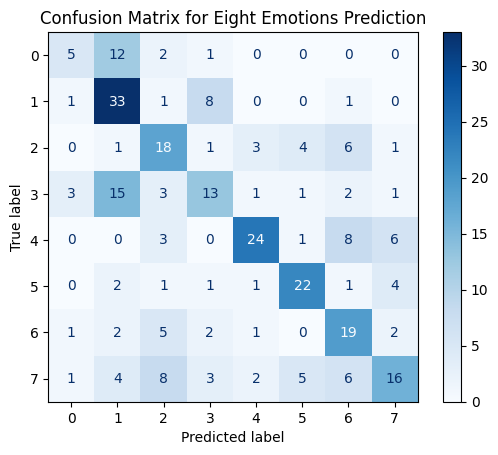

In [100]:
y_pred = rf_selected.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Step 6: Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Eight Emotions Prediction')
plt.show()
